# Settings

In [1]:
import os
import subprocess

import tqdm
import pyfaidx
import yaml

import igver

In [2]:
import pysam
import pyfaidx

import io
from PIL import Image, ImageDraw, ImageFont
import numpy as np

In [3]:
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
def create_letter_image(letter='A', img_size=(120, 250), font_size=110, ttf="../data/fonts/RobotoMono-Bold.ttf"):
    """Creates a white image with a black letter centered."""
    img = Image.new('L', img_size, color=255)
    draw = ImageDraw.Draw(img)
    
    try:
        font = ImageFont.truetype(ttf, font_size)
    except IOError:
        raise RuntimeError(f"Font not found. Make sure {ttf} is installed.")
    
    # Center the text
    text_bbox = draw.textbbox((0, 0), letter, font=font)
    text_w, text_h = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    position = ((img_size[0] - text_w) // 2, (img_size[1] - text_h) // 2)
    
    draw.text(position, letter, fill=0, font=font)
    return img

def resize_image(img, new_size):
    """Resize the image to new dimensions."""
    return img.resize(new_size, resample=Image.Resampling.BILINEAR)

def image_to_char_matrix(img, fg_char='C', bg_char='A', threshold=128, trim_top=15, trim_side=1):
    """Convert an image to a character matrix: white -> 'A', black -> 'C'."""
    arr = np.array(img)
    matrix = np.where(arr > threshold, bg_char, fg_char)
    return matrix[trim_top:, trim_side:-trim_side]

def collapse_char_matrix(matrix):
    """Collapse the character matrix to string."""
    collapsed = '\n'.join(''.join(row) for row in matrix)
    return collapsed

In [80]:
def create_letter_files(letters, letter_map, out_dir, fg='C', bg='A', resize=(70, 60), trim_top=20, trim_side=10, ttf="../data/fonts/RobotoMono-Bold.ttf"):
    for letter in letters:
        dst_letter = letter_map[letter]
        # Step 1: Create 70x70 image with 'A'
        base_img = create_letter_image(letter, ttf="../data/fonts/RobotoMono-Bold.ttf")
        
        # Step 2: Resize to 70x40 (fat 'A')
        resized_img = resize_image(base_img, resize)
        
        # Step 3: Convert to character matrix
        char_matrix = image_to_char_matrix(resized_img, fg_char=fg, bg_char=bg, trim_top=trim_top, trim_side=trim_side)
        
        # Step 4: Print to stdout
        character = collapse_char_matrix(char_matrix)

        out_path = f'{out_dir}/{dst_letter}.fg{fg}.bg{bg}.txt'
        # print(out_path)
        with open(out_path, 'w') as out:
            out.write(character+'\n')

In [6]:
def make_letter_bam(letter, out_dir, region, fg='C', bg='A'):
    chrom, span = region.split(':')
    start_pos, end_pos = [int(_) for _ in span.split('-')]
    
    bam = f'{out_dir}/{letter}.fg{fg}.bg{bg}.bam'
    
    # Load reference FASTA to get header
    ref_fasta = pysam.FastaFile(fasta_path)
    header = {
        "HD": {"VN": "1.0"},
        "SQ": [{"SN": r, "LN": ref_fasta.get_reference_length(r)} for r in ref_fasta.references]
    }
    ref_id = ref_fasta.references.index(chrom)
    
    # Create BAM file
    with pysam.AlignmentFile(bam, "wb", header=header) as outf:
        for i, seq in enumerate(read_seqs[::-1]):
            a = pysam.AlignedSegment()
            a.query_name = f"read_{i}"
            a.query_sequence = seq
            a.flag = 0  # mapped, forward strand
            a.reference_id = ref_id
            a.reference_start = start_pos
            a.mapping_quality = 60
            a.cigar = [(0, len(seq))]  # match
            a.query_qualities = pysam.qualitystring_to_array("I" * len(seq))  # phred 40
            outf.write(a)
    
    # # Sort and index for IGV
    # subprocess.run(["samtools", "sort", "-o", "custom.sorted.bam", "custom.bam"])
    subprocess.run(["samtools", "index", bam])

In [7]:
def resize_png(fig, out_path):
    # 2. Save figure to a buffer in RGBA format
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=100, bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    
    # 3. Open with PIL
    img = Image.open(buf)
    
    # 4. Crop the image: (left, upper, right, lower)
    # Example: remove 50 pixels from each edge
    # cropped = img.crop(box=(90, 10, img.width - 50, img.height - 20))
    cropped = img.crop(box=(100, 10, img.width-100, img.height-20))
    
    # 5. Resize the image (e.g., downsample or reshape)
    resized = cropped.resize((20, 50), Image.Resampling.LANCZOS)
    
    # 6. Save or display
    resized.save(out_path)
    # resized.show()

# Data

In [13]:
fasta_path = '/data1/shahs3/isabl_data_lake/assemblies/GRCh37/GRCh37-lite/GRCh37-lite.fa'

In [14]:
genome = pyfaidx.Fasta(fasta_path)

In [15]:
contig = genome['1']

In [ ]:
bases = 'ACGT'
stretch_starts = {b:{} for b in bases}
window_size = 70
chroms = [str(c) for c in range(1, 22+1)] + ['X', 'Y']

for chrom in tqdm.tqdm(chroms):
    seq = genome[chrom][:].seq.upper()
    for base in bases:
        stretch = base * window_size
        if stretch in seq:
            start = seq.index(stretch)
            end = start + window_size
            region = f'{chrom}:{start+1}-{end}'
            stretch_starts[base][window_size] = region

stretch_starts

In [27]:
stretch_starts = yaml.safe_load(open('../metadata/regions.yaml'))

# Create letter data

In [28]:
stretch_starts

{'A': {70: '4:1708953-1709022'},
 'C': {},
 'G': {70: '2:33141320-33141389'},
 'T': {70: '15:77910871-77910940'}}

In [78]:
fg = 'C'
bg = 'A'
ws = 70

In [81]:
letters_large = [chr(l) for l in range(ord('A'), ord('Z')+1)] 
letters_int = [str(i) for i in range(10)]
letters_small = [chr(l) for l in range(ord('a'), ord('z')+1)]
letters_misc = [c for c in ';,.\'"{}[]<>?%()!']

letters = letters_large + letters_int + letters_small + letters_misc

letter_map = {x:x for x in letters}
letter_map['.'] = 'dot'
letter_map[','] = 'comma'
letter_map['('] = 'parenthesis0'
letter_map[')'] = 'parenthesis1'
letter_map['!'] = 'exclamation'

ttf = "../data/fonts/RobotoMono-Bold.ttf"
out_dir = '../results/letters'

create_letter_files(letters, letter_map, out_dir, fg=fg, bg=bg, ttf=ttf)

# Make BAM

In [42]:
fasta_path = '/data1/shahs3/isabl_data_lake/assemblies/GRCh37/GRCh37-lite/GRCh37-lite.fa'
fasta = pysam.Fastafile(fasta_path)

In [43]:
chroms = fasta.references
lengths = fasta.lengths

## read seqs

In [82]:
out_dir = '../results/bam'
for letter in letters:
    region = stretch_starts[bg][ws]
    dst_letter = letter_map[letter]
    reads_path = f'../results/letters/{dst_letter}.fg{fg}.bg{bg}.txt'
    read_seqs = [s.strip() for s in open(reads_path).readlines()]
    make_letter_bam(dst_letter, out_dir, region, fg=fg, bg=bg)

# Visualize

In [45]:
region = stretch_starts[bg][ws]
chrom, span = region.split(':')
start_pos, end_pos = [int(_) for _ in span.split('-')]

100%|██████████| 2/2 [00:21<00:00, 10.54s/it]


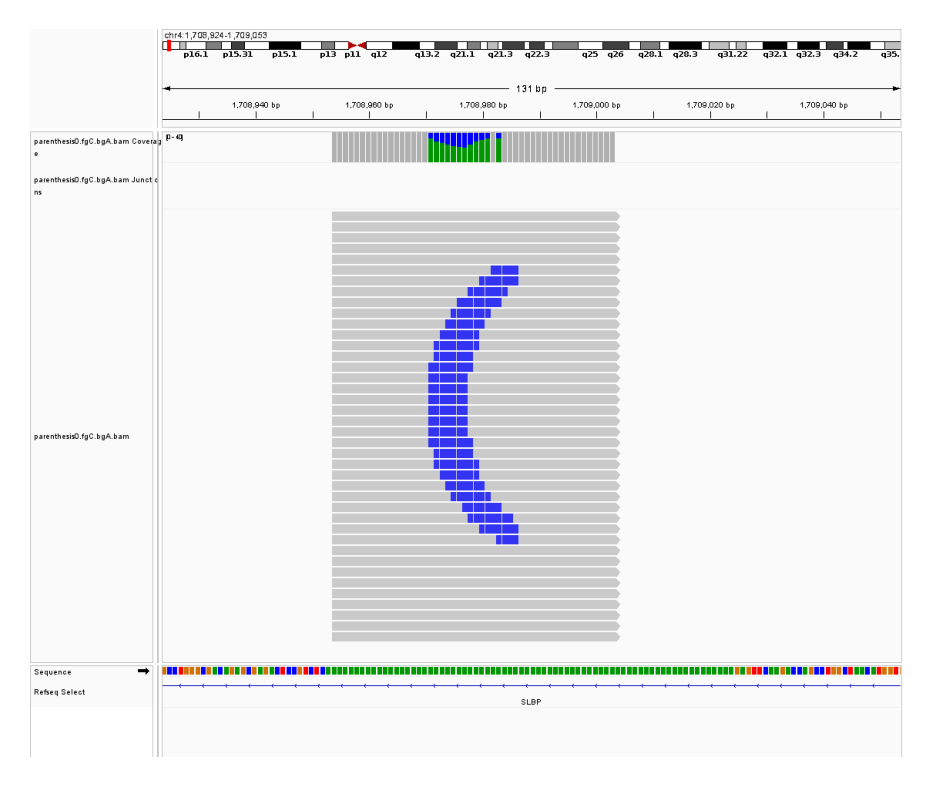

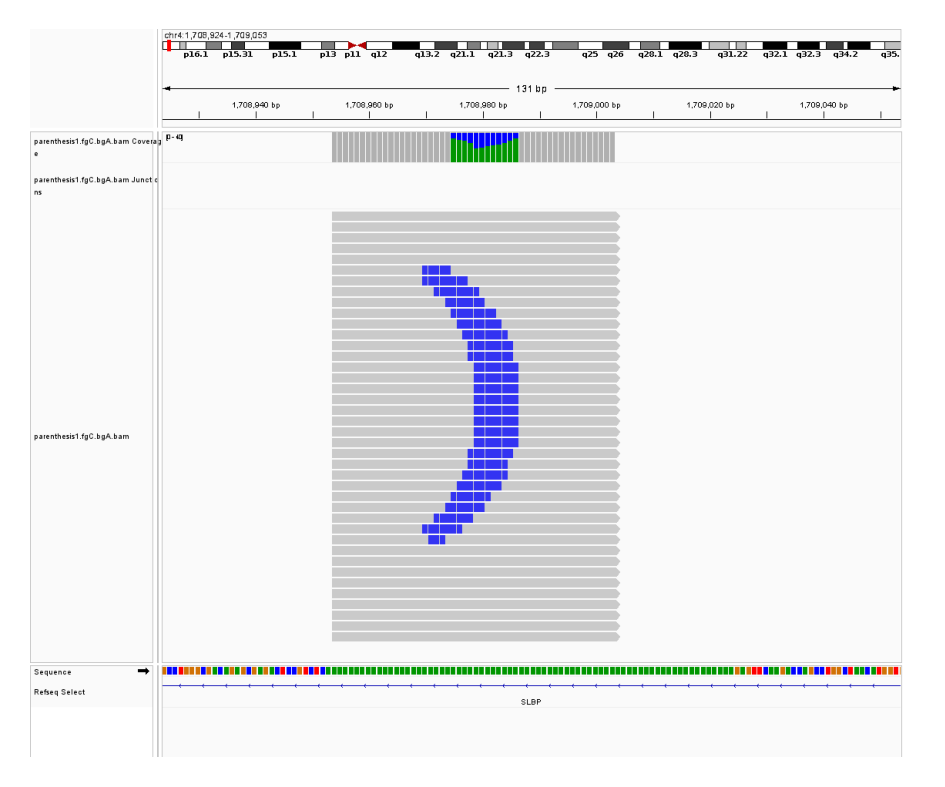

In [86]:
margin = 30
end_pos = start_pos + ws
# for letter in tqdm.tqdm(letters):
for letter in tqdm.tqdm('()'):
    dst_letter = letter_map[letter]
    bam = f'../results/bam/{dst_letter}.fg{fg}.bg{bg}.bam'
    png = f'../results/png/{dst_letter}.fg{fg}.bg{bg}.png'
    png_resized = f'../results/png_resize/{dst_letter}.fg{fg}.bg{bg}.png'
    region = f'{chrom}:{start_pos+1-margin}-{end_pos+margin}'
    figs = igver.load_screenshots([bam], [region], max_panel_height=800, 
                                  overlap_display='expand', 
                                  singularity_args='-B /data1 -B /home')
    fig = figs[0]
    fig.savefig(png)
    resize_png(fig, png_resized)
    # break

# Write message

In [137]:
char2path.keys()

dict_keys(['?', 'T', ',', 'K', 'B', 'M', 'b', 'W', 'Y', 'X', '}', 'm', 'v', 'h', ']', '6', 'z', '<', 't', 'r', 'U', 'I', 'l', 's', 'o', 'P', '2', 'f', 'q', 'S', 'n', 'u', ';', 'y', 'O', 'C', 'a', 'V', 'N', 'Q', '7', '3', '>', 'w', 'd', '9', '5', '4', '"', 'e', 'Z', 'g', 'A', '{', 'R', 'j', "'", 'J', 'i', 'F', '[', '1', 'x', 'E', 'D', 'p', '8', 'L', 'c', '0', 'G', 'H', 'k'])

In [10]:
png_paths[:3]

['../results/png_resize/?.fgC.bgA.png',
 '../results/png_resize/>.fgT.bgA.png',
 '../results/png_resize/T.fgC.bgA.png']

In [112]:
png_dir = f'../results/png_resize'

fg, bg = 'C', 'A'
png_paths = glob.glob(f'{png_dir}/*.fg{fg}.bg{bg}.png')
char2path = {os.path.split(p)[-1].split('.')[0]: p for p in png_paths}
char2path['.'] = '../results/png_resize/dot.fgC.bgA.png'
char2path[','] = '../results/png_resize/comma.fgC.bgA.png'
char2path['('] = '../results/png_resize/parenthesis0.fgC.bgA.png'
char2path[')'] = '../results/png_resize/parenthesis1.fgC.bgA.png'
char2path['!'] = '../results/png_resize/exclamation.fgC.bgA.png'

# fg, bg = 'T', 'A'
png_paths = glob.glob(f'{png_dir}/*.fgT.bg{bg}.png')
char2path_red = {os.path.split(p)[-1].split('.')[0]: p for p in png_paths}
char2path_red['.'] = '../results/png_resize/dot.fgC.bgA.png'
char2path_red[','] = '../results/png_resize/comma.fgC.bgA.png'
char2path_red['('] = '../results/png_resize/parenthesis0.fgC.bgA.png'
char2path_red[')'] = '../results/png_resize/parenthesis1.fgC.bgA.png'
char2path_red['!'] = '../results/png_resize/exclamation.fgC.bgA.png'

In [125]:
! git push

Everything up-to-date


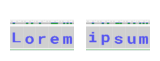

In [122]:
# 2. The text to layout
line_spacing = 1.3
message = (
"""Lorem ipsum"""
)

# 3. Load one sample to get image size
sample_img = mpimg.imread(next(iter(char2path.values())))
img_h, img_w = sample_img.shape[:2]

# 4. Parse layout string
lines = message.split('\n')
n_rows = len(lines)
n_cols = max(len(line) for line in lines)  # counts ' ' too

# 5. Setup plot
fig_w = img_w * n_cols / 70
fig_h = img_h * n_rows / 70
fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=100)
ax.set_xlim(0, img_w * n_cols)
ax.set_ylim(0, img_h * n_rows * line_spacing)
ax.axis('off')

# 6. Draw each character
path_map = char2path
write_red = False
for row_idx, line in enumerate(lines[::-1]):  # matplotlib plots bottom-up
    col_idx = -1
    for j, ch in enumerate(line):
        col_idx += 1
        if ch == ' ':
            continue
        if ch == '_':
            col_idx -= 1
            if not write_red:
                write_red = True
            else:
                write_red = False
            continue
        # if ch not in path_map:
        #     continue
        path_map = char2path
        if write_red:
            path_map = char2path_red
        img = mpimg.imread(path_map[ch])
        x0 = col_idx * img_w
        y0 = row_idx * img_h * line_spacing  # ← adjusted for double spacing
        ax.imshow(img, extent=[x0, x0 + img_w, y0, y0 + img_h])

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

In [69]:
for png_path in png_paths:
    assert os.path.exists(png_path)